# Import Required Libraries

In [12]:
import torch
from transformers import (
    BertTokenizer, BertConfig, BertForMaskedLM, Trainer, TrainingArguments, 
    DataCollatorForLanguageModeling, PreTrainedTokenizerFast, BertForQuestionAnswering, 
    BertForTokenClassification, BertTokenizerFast, DataCollatorForTokenClassification
)
from datasets import load_dataset
from sklearn.metrics import f1_score
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
import math
import matplotlib.pyplot as plt

# Define Tokenizer Types and Models

In [3]:
tokenizer_types = ["Unigram", "BPE", "Wordpiece"]
tasks = ["TextGeneration", "QnsAns", "NER"]

# Evaluate Text Generation Model

In [8]:
def evaluate_text_generation(tokenizer_type):
    tokenizer_file = f"tokenizers/{tokenizer_type.lower()}-tokenizer.json"
    tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_file)
    tokenizer.add_special_tokens({'pad_token': '[PAD]', 'mask_token': '[MASK]', 'unk_token': '[UNK]'})
    model = BertForMaskedLM.from_pretrained(f"{tokenizer_type}_BERT_TextGeneration")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    dataset = load_dataset('euclaise/writingprompts')
    def tokenize_function(examples):
        return tokenizer(examples['story'], padding='max_length', truncation=True, max_length=128)
    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    def calculate_perplexity(text):
        inputs = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs['input_ids'])
        loss = outputs.loss
        perplexity = math.exp(loss.item())
        return perplexity
    perplexities = []
    for example in tokenized_datasets['test']:
        text = example['story']
        perplexity = calculate_perplexity(text)
        perplexities.append(perplexity)
    average_perplexity = sum(perplexities) / len(perplexities)
    return average_perplexity

# Evaluate Question Answering Model

In [9]:
def evaluate_question_answering(tokenizer_type):
    tokenizer_file = f"tokenizers/{tokenizer_type.lower()}-tokenizer.json"
    tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_file)
    tokenizer.add_special_tokens({'pad_token': '[PAD]', 'mask_token': '[MASK]', 'unk_token': '[UNK]'})
    model = BertForQuestionAnswering.from_pretrained(f"{tokenizer_type}_BERT_QnsAns")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    dataset = load_dataset('squad')
    def tokenize_function(examples):
        return tokenizer(examples['question'], examples['context'], truncation=True, padding='max_length', max_length=128)
    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    def make_predictions(examples):
        inputs = tokenizer(examples['question'], examples['context'], return_tensors='pt', truncation=True, padding='max_length', max_length=128)
        inputs = {key: value.to(model.device) for key, value in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits
        start_index = torch.argmax(start_logits, dim=1).item()
        end_index = torch.argmax(end_logits, dim=1).item()
        return tokenizer.decode(inputs['input_ids'][0][start_index:end_index+1])
    predictions = []
    references = []
    for example in tokenized_datasets['validation']:
        prediction = make_predictions(example)
        predictions.append(prediction)
        references.append(example['answers']['text'][0])
    def compute_exact_match(predictions, references):
        return sum([1 if pred == ref else 0 for pred, ref in zip(predictions, references)]) / len(references)
    def compute_f1(predictions, references):
        f1_scores = []
        for pred, ref in zip(predictions, references):
            pred_tokens = pred.split()
            ref_tokens = ref.split()
            common_tokens = set(pred_tokens) & set(ref_tokens)
            if len(common_tokens) == 0:
                f1_scores.append(0)
            else:
                precision = len(common_tokens) / len(pred_tokens)
                recall = len(common_tokens) / len(ref_tokens)
                f1_scores.append(2 * (precision * recall) / (precision + recall))
        return sum(f1_scores) / len(f1_scores)
    exact_match = compute_exact_match(predictions, references)
    f1 = compute_f1(predictions, references)
    return exact_match, f1

# Evaluate Named Entity Recognition Model

In [14]:
def evaluate_ner(tokenizer_type):
    tokenizer_file = f"tokenizers/{tokenizer_type.lower()}-tokenizer.json"
    tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_file)
    tokenizer.add_special_tokens({'pad_token': '[PAD]', 'mask_token': '[MASK]', 'unk_token': '[UNK]'})
    model = BertForTokenClassification.from_pretrained(f"{tokenizer_type}_BERT_NER")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    dataset = load_dataset("conll2003")
    def tokenize_and_align_labels(examples):
        tokenized_inputs = tokenizer(examples['tokens'], truncation=True, padding='max_length', max_length=128, is_split_into_words=True)
        labels = []
        for i, label in enumerate(examples['ner_tags']):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            label_ids = []
            previous_word_idx = None
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:
                    label_ids.append(label[word_idx])
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx
            labels.append(label_ids)
        tokenized_inputs["labels"] = labels
        return tokenized_inputs
    tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)
    def compute_metrics(p):
        predictions, labels = p
        predictions = np.argmax(predictions, axis=2)
        true_labels = [[label for label in label if label != -100] for label in labels]
        true_predictions = [
            [pred for pred, label in zip(prediction, label) if label != -100]
            for prediction, label in zip(predictions, labels)
        ]
        label_list = dataset['train'].features['ner_tags'].feature.names
        true_labels = [[label_list[l] for l in label] for label in true_labels]
        true_predictions = [[label_list[p] for p in prediction] for prediction in true_predictions]
        precision = precision_score(true_labels, true_predictions)
        recall = recall_score(true_labels, true_predictions)
        f1 = f1_score(true_labels, true_predictions)
        return {
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }
    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy='epoch',
        learning_rate=1e-4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        fp16=True,
        save_strategy='no',
        logging_strategy='epoch'
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=tokenized_datasets['test'],
        compute_metrics=compute_metrics
    )
    results = trainer.evaluate()
    return results['eval_precision'], results['eval_recall'], results['eval_f1']

# Compare Tokenizer Types for Each Task

In [15]:
results = {"TextGeneration": {}, "QnsAns": {}, "NER": {}}

for tokenizer_type in tokenizer_types:
    print(f"\nEvaluating {tokenizer_type} Tokenizer")
    print("Text Generation:")
    avg_perplexity = evaluate_text_generation(tokenizer_type)
    results["TextGeneration"][tokenizer_type] = avg_perplexity
    print(f"Average Perplexity: {avg_perplexity}")
    print("\nQuestion Answering:")
    exact_match, f1 = evaluate_question_answering(tokenizer_type)
    results["QnsAns"][tokenizer_type] = {"Exact Match": exact_match, "F1": f1}
    print(f"Exact Match: {exact_match}")
    print(f"F1-Score: {f1}")
    print("\nNamed Entity Recognition:")
    precision, recall, f1 = evaluate_ner(tokenizer_type)
    results["NER"][tokenizer_type] = {"Precision": precision, "Recall": recall, "F1": f1}
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")


Evaluating Unigram Tokenizer
Text Generation:


Map: 100%|██████████| 15620/15620 [00:07<00:00, 2021.92 examples/s]


Average Perplexity: 3.3705515735536604

Question Answering:
Exact Match: 0.013623462630085147
F1-Score: 0.014543181511015002

Named Entity Recognition:


Map: 100%|██████████| 3453/3453 [00:00<00:00, 4910.13 examples/s]
/home/elicer/.local/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Precision: 0.3924088022448678
Recall: 0.47201989696216023
F1-Score: 0.42854838709677423

Evaluating BPE Tokenizer
Text Generation:


Map: 100%|██████████| 15620/15620 [00:06<00:00, 2469.28 examples/s]


Average Perplexity: 2.2394253348206776

Question Answering:


Map: 100%|██████████| 10570/10570 [00:01<00:00, 6550.94 examples/s]


Exact Match: 0.018543046357615896
F1-Score: 0.020924275976310032

Named Entity Recognition:


Map: 100%|██████████| 3453/3453 [00:00<00:00, 7451.39 examples/s]
/home/elicer/.local/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Precision: 0.34981040086673887
Recall: 0.45789753589789045
F1-Score: 0.39662188099808054

Evaluating Wordpiece Tokenizer
Text Generation:


Map: 100%|██████████| 15620/15620 [00:13<00:00, 1126.76 examples/s]


Average Perplexity: 149.46750314439237

Question Answering:


Map: 100%|██████████| 10570/10570 [00:04<00:00, 2261.81 examples/s]


Exact Match: 0.0
F1-Score: 0.0

Named Entity Recognition:


Map: 100%|██████████| 3453/3453 [00:00<00:00, 6745.82 examples/s]
/home/elicer/.local/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Precision: 0.31240012783636945
Recall: 0.37033529077476796
F1-Score: 0.338909595215394


# Visualize Results

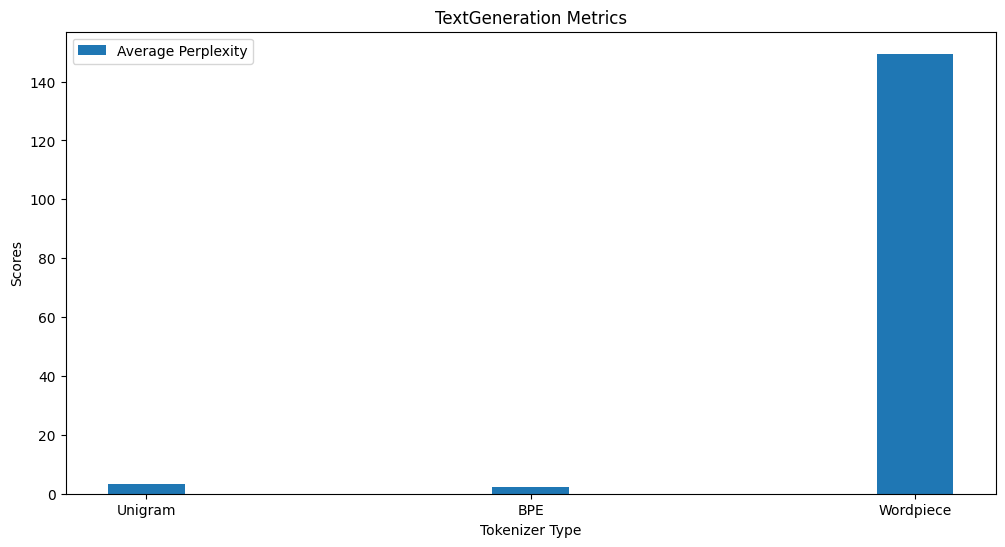

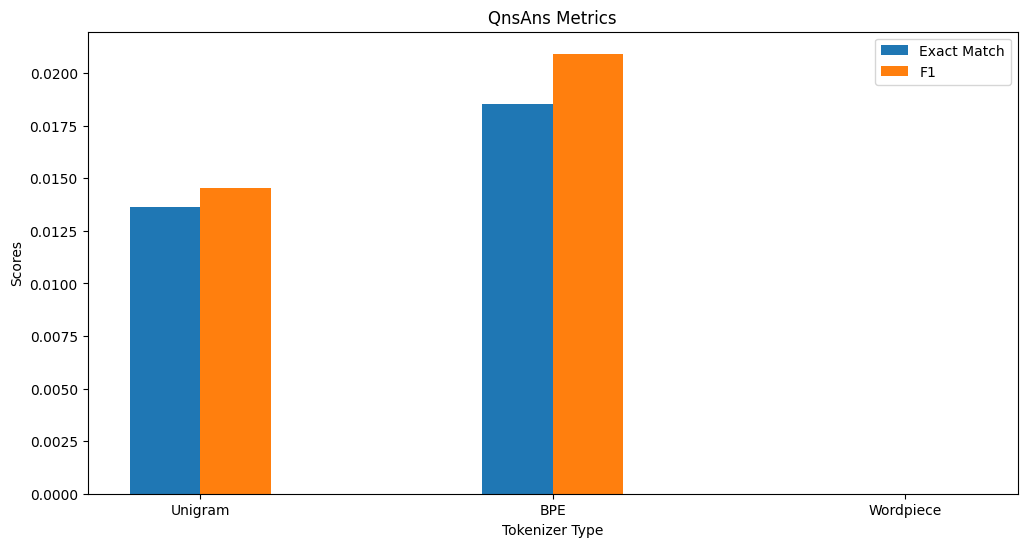

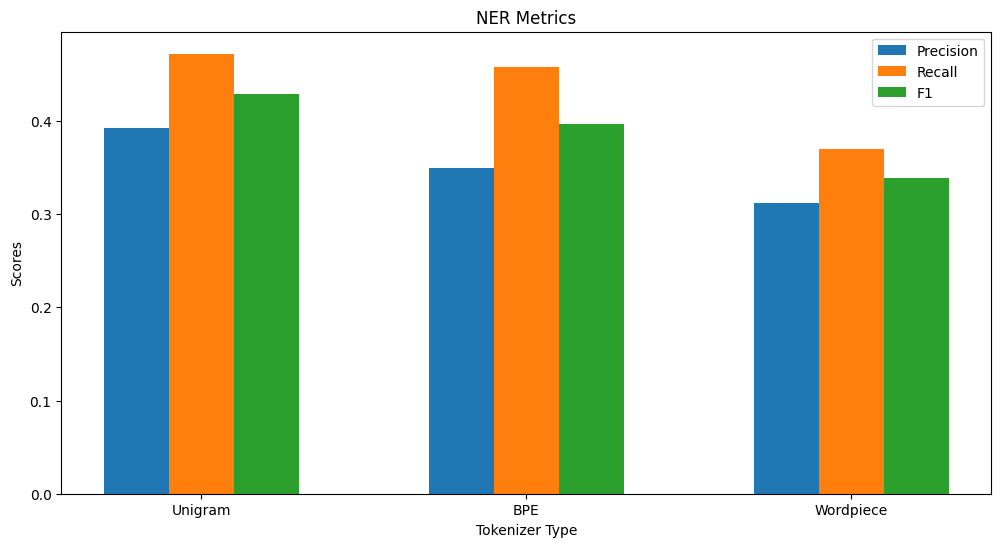

In [19]:
def plot_grouped_bar_chart(results, task, metrics):
    tokenizer_types = list(results[task].keys())
    n_metrics = len(metrics)
    bar_width = 0.2
    index = np.arange(len(tokenizer_types))

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, metric in enumerate(metrics):
        values = [results[task][tokenizer_type][metric] if isinstance(results[task][tokenizer_type], dict) else results[task][tokenizer_type] for tokenizer_type in tokenizer_types]
        ax.bar(index + i * bar_width, values, bar_width, label=metric)

    ax.set_xlabel('Tokenizer Type')
    ax.set_ylabel('Scores')
    ax.set_title(f'{task} Metrics')
    ax.set_xticks(index + bar_width * (n_metrics - 1) / 2)
    ax.set_xticklabels(tokenizer_types)
    ax.legend()

    plt.show()

# Plot results for each task
plot_grouped_bar_chart(results, "TextGeneration", ["Average Perplexity"])
plot_grouped_bar_chart(results, "QnsAns", ["Exact Match", "F1"])
plot_grouped_bar_chart(results, "NER", ["Precision", "Recall", "F1"])